# Part 2

In [14]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from torch.utils.data import Dataset
from PIL import Image
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
import warnings
warnings.filterwarnings("ignore")
import glob


In [5]:
masks = glob.glob("/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/*/*_mask.png")

In [24]:
images = [mask_images.replace("_mask", "") for mask_images in masks]
series = list(zip(images, masks))
dataset = pd.DataFrame(series, columns=['image_path', 'mask_path'])
dataset

,image_path,mask_path
0,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...
1,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...
2,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...
3,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...
4,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...
...,...,...
775,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...
776,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...
777,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...
778,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...


In [25]:


class BreastcancerDataset(Dataset):
    np.random.seed(42)
    torch.manual_seed(42)
    def __init__(self, dataframe, image_transform=None):
        self.data = dataframe
        self.image_transform = image_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]['image_path']
        mask_path = self.data.iloc[idx]['mask_path']

        image = Image.open(image_path).convert('L') 
        mask = Image.open(mask_path).convert('L')

        if self.image_transform:
            image = self.image_transform(image)
            mask = self.image_transform(mask)

        return image, mask

def split_data(dataframe, train_frac=0.8, val_frac=0.1, test_frac=0.1):
    
    total_len = len(dataframe)
    train_len = int(train_frac * total_len)
    val_len = int(val_frac * total_len)
    test_len = total_len - train_len - val_len

    # Ensure the fractions add up to 1
    assert train_len + val_len + test_len == total_len

    # Shuffle the indices
    indices = np.random.permutation(total_len)

    train_indices = indices[:train_len]
    val_indices = indices[train_len:train_len + val_len]
    test_indices = indices[train_len + val_len:]

    # Split the dataframe
    train_df = dataframe.iloc[train_indices]
    val_df = dataframe.iloc[val_indices]
    test_df = dataframe.iloc[test_indices]

    return train_df, val_df, test_df

# Split the data
train, val, test = split_data(dataset)

# Transformations 
image_size = 128
    
train_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),
])

# Create datasets
train_dataset = BreastcancerDataset(train, train_transforms)
val_dataset = BreastcancerDataset(val, val_transforms)
test_dataset = BreastcancerDataset(test, val_transforms)

# Create DataLoaders
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# for batches
print("Size of training dataset:", len(train_loader))
print("Size of validation dataset:", len(val_loader))
print("Size of testing dataset:", len(test_loader))

Size of training dataset: 39
Size of validation dataset: 5
Size of testing dataset: 5


In [26]:
for batch in train_loader:
    inputs, targets = batch
    
    # Print the shapes
    print("Input shape:", inputs.shape)
    print("Target shape:", targets.shape)
    break

Input shape: torch.Size([16, 1, 128, 128])
Target shape: torch.Size([16, 1, 128, 128])


In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [32]:
class NN(nn.Module):
    def __init__(self, input_channel, out_channel, dropout):
        super(NN, self).__init__()
        
        self.conv2d_1 = nn.Conv2d(input_channel, out_channel, kernel_size=3, padding=1)
        self.batchnorm_1 = nn.BatchNorm2d(out_channel)
        self.relu_1 = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.conv2d_2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1)
        self.batchnorm_2 = nn.BatchNorm2d(out_channel)
        self.relu_2 = nn.ReLU()

    def forward(self, x):
        
        x = self.conv2d_1(x)
        x = self.batchnorm_1(x)
        x = self.relu_1(x)
        x = self.dropout(x)
        x = self.conv2d_2(x)
        x = self.batchnorm_2(x)
        x = self.relu_2(x)

        return x

class Encoder(nn.Module):
    
    def __init__(self, input_channel, out_channel, dropout):
        super(Encoder, self).__init__()
        self.conv2d_1 = NN(input_channel, out_channel, dropout)
        self.maxpool = nn.MaxPool2d((2,2))
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        x = self.conv2d_1(x)
        p = self.maxpool(x)
        p = self.dropout(p)

        return p

class Decoder(nn.Module):
    def __init__(self, input_channel, output_channel, dropout):
        super(Decoder, self).__init__()
        self.conv_t = nn.ConvTranspose2d(input_channel, output_channel, stride=2, kernel_size=2)
        self.conv2d_1 = NN(output_channel, output_channel, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.conv_t(x)
        x = self.dropout(x)
        x = self.conv2d_1(x)

        return x

class Net(nn.Module):

    def __init__(self, input_channel=1):
        super().__init__()
        self.encoder_1 = Encoder(input_channel, 64, 0.07)
        self.encoder_2 = Encoder(64, 128, 0.08)
        self.encoder_3 = Encoder(128, 256, 0.09)
        self.encoder_4 = Encoder(256, 512, 0.1)

        self.conv_block = NN(512, 1024, 0.11)

        self.decoder_1 = Decoder(1024, 512, 0.1)
        self.decoder_2 = Decoder(512, 256, 0.09)
        self.decoder_3 = Decoder(256, 128, 0.08)
        self.decoder_4 = Decoder(128, 64, 0.07)

        self.cls = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        self.relu = nn.Sigmoid() 

    def forward(self, x):

        # Enoder
        p1 = self.encoder_1(x)
        p2 = self.encoder_2(p1)
        p3 = self.encoder_3(p2)
        p4 = self.encoder_4(p3)

        # Bottleneck
        x = self.conv_block(p4)

        # Decoder
        x = self.decoder_1(x)
        x = self.decoder_2(x)
        x = self.decoder_3(x)
        x = self.decoder_4(x)
        
        #Last Layer
        xfinal = self.cls(x)
        xfinal = self.relu(xfinal)

        return xfinal


In [33]:
class Training:
    def __init__(self, model, num_epochs, optimizer, criterion, device):
        self.num_epochs = num_epochs
        self.optimizer = optimizer
        self.criterion = criterion
        self.model = model
        self.device = device
        self.log_interval = 15

        # Lists to store training and validation metrics
        self.train_losses = []
        self.val_losses = []
        self.train_dices = []
        self.val_dices = []

        # Best model and its metrics
        self.best_model = None
        self.best_dice = 0.0
        self.best_epoch = 0

    def dice_coeff(self, predicted, target, smooth=1e-5):
        intersection = torch.sum(predicted * target)
        union = torch.sum(predicted) + torch.sum(target)
        dice = (2. * intersection + smooth) / (union + smooth)
        return dice
    
    def iou(self, pred_mask, true_mask):
        intersection = torch.logical_and(pred_mask, true_mask).sum().item()
        union = torch.logical_or(pred_mask, true_mask).sum().item()
        iou_score = intersection / union if union != 0 else 0.0
        return iou_score

    def save_best_model(self, epoch, dice):
        if dice > self.best_dice:
            self.best_dice = dice
            self.best_epoch = epoch
            self.best_model = self.model.state_dict()

            filename = f'best_model_epoch{epoch}_dice{dice:.4f}.pth'
            torch.save(self.best_model, filename)

    def train(self, train_loader, val_loader):
        for epoch in range(self.num_epochs):
            train_loss = 0.0
            val_loss = 0.0
            train_dice = 0.0
            val_dice = 0.0

            # Training 
            for i, (images, masks) in enumerate(train_loader):
                images, masks = images.to(self.device), masks.to(self.device)

                self.model.train()
                self.optimizer.zero_grad()

                outputs = self.model(images)
                loss = self.criterion(outputs, masks)
                dice = self.dice_coeff(outputs, masks)

                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                train_dice += dice

                if (i + 1) % self.log_interval == 0:
                    print(f'Epoch [{epoch + 1}/{self.num_epochs}], Loss: {loss.item():.4f}, Dice Coef: {dice:.4f}')

            # Validation 
            self.model.eval()
            with torch.no_grad():
                for images, masks in val_loader:
                    images, masks = images.to(self.device), masks.to(self.device)
                    outputs = self.model(images)
                    val_loss += self.criterion(outputs, masks).item()
                    val_dice += self.dice_coeff(outputs, masks)

            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(val_loader)
            avg_train_dice = train_dice / len(train_loader)
            avg_val_dice = val_dice / len(val_loader)

            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Train Dice: {avg_train_dice:.4f}, Val Dice: {avg_val_dice:.4f}')

            # Save metrics
            self.train_losses.append(avg_train_loss)
            self.val_losses.append(avg_val_loss)
            self.train_dices.append(avg_train_dice)
            self.val_dices.append(avg_val_dice)

            # Save best model
            self.save_best_model(epoch + 1, avg_val_dice)
    def get_metrics(self):
        return {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_dices': self.train_dices,
            'val_dices': self.val_dices,
            'best_model': self.best_model,
            'best_dice': self.best_dice,
            'best_epoch': self.best_epoch
        }

In [34]:
def dice_coef_loss(inputs, target):
    smooth = 1e-6
    intersection = 2.0 * (target*inputs).sum() + smooth
    union = target.sum() + inputs.sum() + smooth
    return 1 - (intersection/union)

def bce_dice_loss(inputs, target):
    dice_score = dice_coef_loss(inputs, target)
    bce_loss = nn.BCELoss()
    bce_score = bce_loss(inputs, target)
    
    return bce_score + dice_score

In [36]:
unet = Net(1).to(device)

In [37]:
learning_rate = 0.001
weight_decay = 1e-6  
optimizer = optim.Adam(unet.parameters(), lr=learning_rate, weight_decay=weight_decay)

trainer = Training(model=unet, num_epochs=3, optimizer=optimizer, criterion=bce_dice_loss, device=device)

In [38]:
trainer.train(train_loader, test_loader)
metrics = trainer.get_metrics()

Epoch [1/3], Loss: 1.2729, Dice Coef: 0.1039
Epoch [1/3], Loss: 1.0367, Dice Coef: 0.2720
Epoch [1/3], Train Dice: 0.2110, Val Dice: 0.2403
Epoch [2/3], Loss: 0.8957, Dice Coef: 0.3464
Epoch [2/3], Loss: 0.8053, Dice Coef: 0.4028
Epoch [2/3], Train Dice: 0.3299, Val Dice: 0.4081
Epoch [3/3], Loss: 0.7801, Dice Coef: 0.4378
Epoch [3/3], Loss: 0.8968, Dice Coef: 0.3639
Epoch [3/3], Train Dice: 0.4234, Val Dice: 0.4816


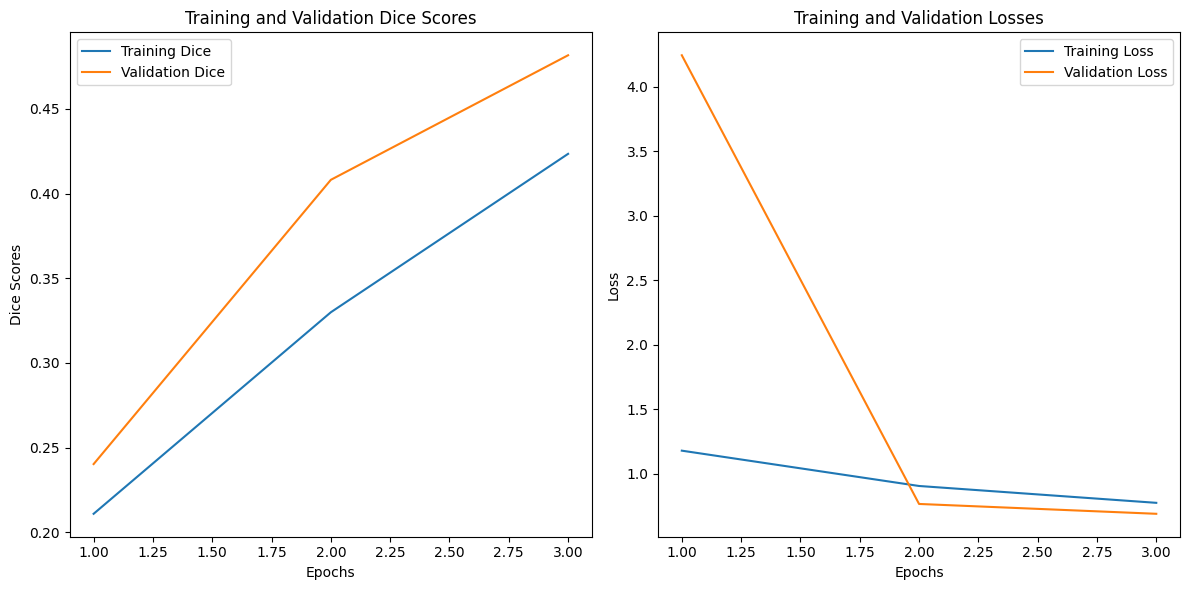

In [39]:
def to_numpy(tensor):
    # Move tensor to CPU and convert to NumPy array
    return tensor.cpu().detach().item()

def plot_curves(metrics):
    num_epochs = len(metrics['train_losses'])
    epochs = np.arange(1, num_epochs + 1)

    train_lossarray = metrics['train_losses']     # Convert tensors to NumPy arrays
    val_lossarray = metrics['val_losses']
    train_dicearray = [to_numpy(dice) for dice in metrics['train_dices']]
    val_dicearray = [to_numpy(dice) for dice in metrics['val_dices']]

    # Plot Dice Scores
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_dicearray, label='Training Dice')
    plt.plot(epochs, val_dicearray, label='Validation Dice')
    plt.title('Training and Validation Dice Scores')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Scores')
    plt.legend()


    # Plot Losses
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_lossarray, label='Training Loss')
    plt.plot(epochs, val_lossarray, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_curves(metrics)


In [40]:
def test(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_masks = []
    dice_scores = []

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            predictions = (outputs > 0.5).float()  # Threshold predictions
            all_predictions.append(predictions.cpu().numpy())
            all_masks.append(masks.cpu().numpy())

            # Calculate Dice score for each batch
            dice_batch = [dice_coeff(pred, mask) for pred, mask in zip(predictions, masks)]
            dice_scores.extend(dice_batch)

    # Convert lists to numpy arrays
    all_predictions = np.concatenate(all_predictions)
    all_masks = np.concatenate(all_masks)

    # Calculate overall test accuracy
    accuracy = (all_predictions == all_masks).mean()

    return all_predictions, all_masks, accuracy, dice_scores

def dice_coeff(predicted, target, smooth=1e-5):
    intersection = torch.sum(predicted * target)
    union = torch.sum(predicted) + torch.sum(target)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice


# Test the model
predictions, masks, accuracy, dice_scores = test(unet, test_loader, device)

# Plot the test accuracy
print("Test Accuracy:", accuracy)

# Report the Dice score
average_dice = np.mean(dice_scores)
print("Average Dice Score:", average_dice)


Test Accuracy: 0.937339587089343
Average Dice Score: 0.468796


In [41]:
import matplotlib.pyplot as plt
import numpy as np

def to_numpy(tensor):
    # Move tensor to CPU and convert to NumPy array
    return tensor.cpu().detach().numpy()

def threshold_prediction(predicted, threshold=0.5):
    # Threshold predicted values
    predicted[predicted < threshold] = 0
    predicted[predicted >= threshold] = 1
    return predicted

def plot_subplots(image, mask, predicted, threshold=0.5):
    # Convert tensors to NumPy arrays
    image_np, mask_np, predicted_np = map(to_numpy, (image, mask, predicted))

    # Threshold the predicted values
    predicted_np_thresholded = threshold_prediction(predicted_np, threshold)

    fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # Adjust figsize as needed

    # Plot Image, Mask, Predicted, and Thresholded Predicted
    titles = ['Image', 'True Mask', 'Predicted Mask']
    for ax, data, title in zip(axes, [image_np, mask_np, predicted_np, predicted_np_thresholded], titles):
        ax.imshow(data.squeeze(), cmap='gray' if 'Mask' in title else 'gray')
        ax.set_title(title)
        ax.axis('off')

    plt.show()

Correct Predictions:


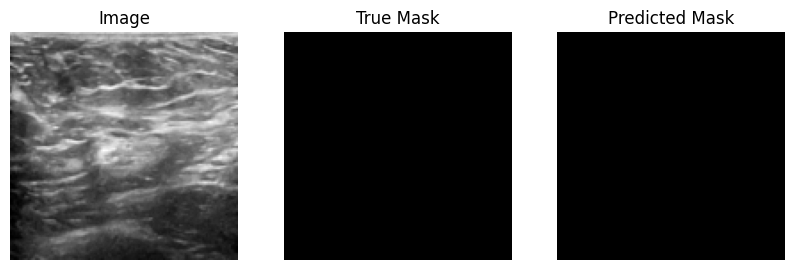

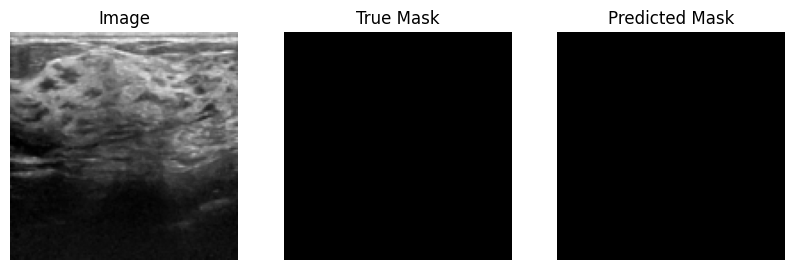

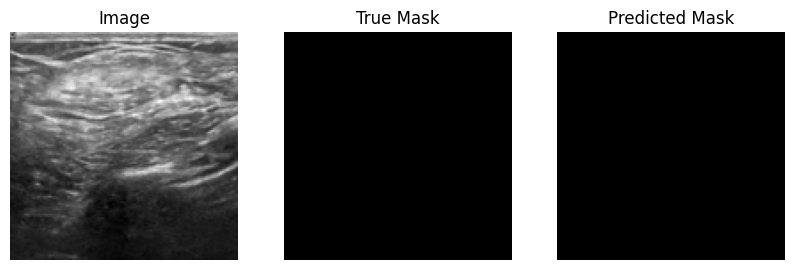

Wrong Predictions:


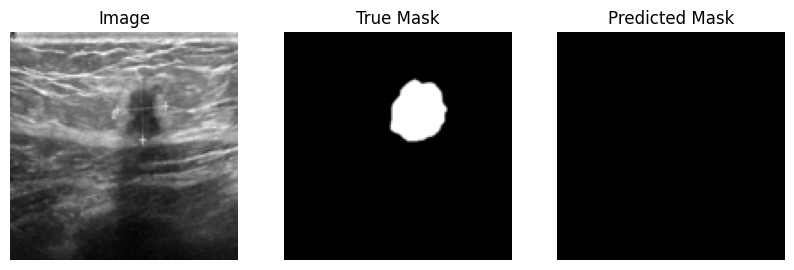

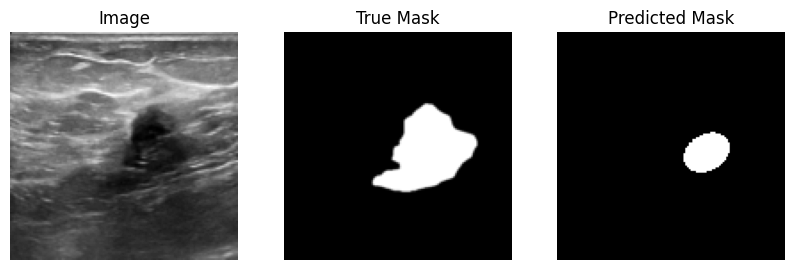

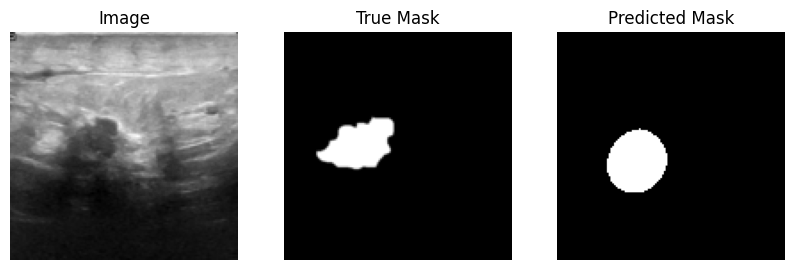

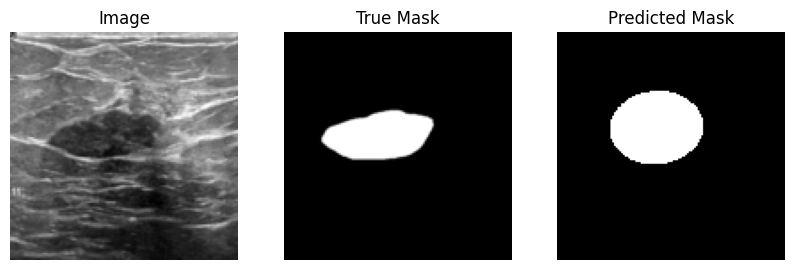

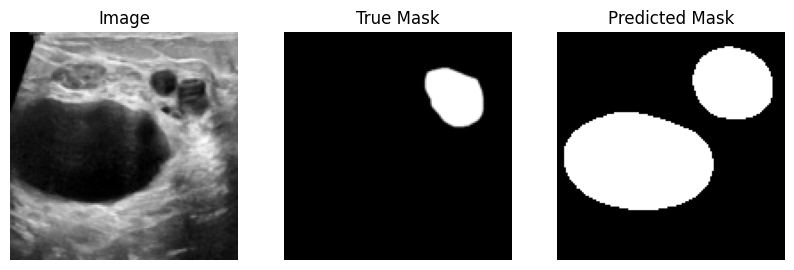

In [48]:
def is_prediction_correct(pred, mask, threshold=0.5):
  
    pred_binary = (pred > threshold).float()
    mask_binary = (mask > threshold).float()
    return torch.all(torch.eq(pred_binary, mask_binary))

correct_predictions = []
wrong_predictions = []

for i in range(10):
    image, mask = train_dataset[i]
    im = image.to(device)
    pred = unet(im.unsqueeze(0))
    pred = pred.squeeze()

    if is_prediction_correct(pred, mask):
        correct_predictions.append((image, mask, pred))
    else:
        wrong_predictions.append((image, mask, pred))

# Plot correct predictions
print("Correct Predictions:")
for image, mask, pred in correct_predictions[:5]:
    plot_subplots(image, mask, pred)

# Plot wrong predictions
print("Wrong Predictions:")
for image, mask, pred in wrong_predictions[:5]:
    plot_subplots(image, mask, pred)


Enter the path to the image:  /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (10).png
Enter the path to the true mask:  /kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (10)_mask.png


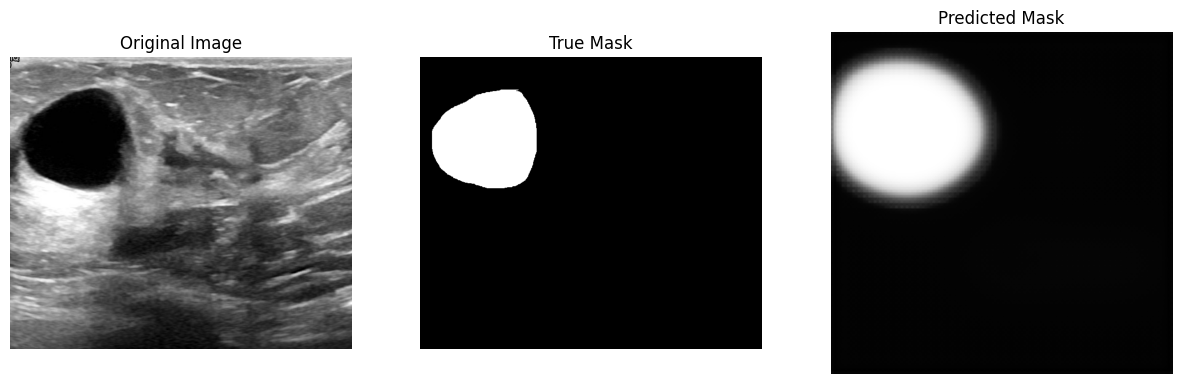

In [57]:
#RUNTIME TESTING
def plot_mask_prediction(image, true_mask, mask_pred):

    plt.figure(figsize=(15, 5))
    
    # Plot original image
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Plot true mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title('True Mask')
    plt.axis('off')

    # Plot predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(mask_pred, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

def runtime_testing(model):

    image_path = input("Enter the path to the image: ")
    true_mask_path = input("Enter the path to the true mask: ")

    image = Image.open(image_path)
    true_mask = Image.open(true_mask_path).convert('L')
    true_mask = np.array(true_mask)

    mask_pred = predict_mask(model, image_path)
    plot_mask_prediction(image, true_mask, mask_pred)


runtime_testing(unet)  


In [ ]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Step 1: Modify your model to return the output of the last layer of the encoder
encoder_output_list = []

# Set the model to evaluation mode
unet.eval()

with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        # Forward pass through the model
        encoder_output = unet.encoder_4(images)  # Assuming encoder_4 is the last layer of the encoder
        encoder_output_list.append(encoder_output.cpu().numpy())

# Concatenate the encoder outputs from different batches
encoder_outputs = np.concatenate(encoder_output_list, axis=0)

# Step 2: Use TSNE to reduce the dimensionality of the encoder output
tsne = TSNE(n_components=2, random_state=42)
tsne_representation = tsne.fit_transform(encoder_outputs)

# Step 3: Plot the TSNE representation with the corresponding labels
labels_list = []

for _, labels_batch in train_loader:
    labels_list.append(labels_batch.numpy())

# Concatenate the labels from different batches
labels_array = np.concatenate(labels_list, axis=0)

# Plot the TSNE representation
plt.figure(figsize=(10, 8))
for i in np.unique(labels_array):
    indices = labels_array == i
    plt.scatter(tsne_representation[indices, 0], tsne_representation[indices, 1], label=f'Class {i}')
plt.legend()
plt.title('TSNE Representation of Encoder Output with Labels')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.show()
